In [2]:
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    TrainingArguments,
    Trainer
)
import numpy as np
from itertools import chain

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PARQUET_PATH = "/content/drive/MyDrive/DL_project/dataset/tokens/tracks_with_ids.parquet"


df = pd.read_parquet(PARQUET_PATH)

In [6]:
# 2. Sort & group into sequences
#    - sort by playlist, then track_pos
#    - groupby playlist_pid, collect track_id into Python lists
seqs_pd = (
    df
    .sort_values(["playlist_pid", "track_pos"])
    .groupby("playlist_pid", as_index=False)["track_id"]
    .apply(list)
    .rename(columns={"track_id": "track_sequence"})
)

In [7]:
# 3. Filter out any playlists shorter than 2
seqs_pd["length"] = seqs_pd["track_sequence"].map(len)
seqs_pd = seqs_pd[seqs_pd["length"] >= 30].reset_index(drop=True)

In [8]:
# 4. Train/Val/Test split (80/10/10)
train_df, tmp_df = train_test_split(seqs_pd, test_size=0.2, random_state=42)
val_df,  test_df = train_test_split(tmp_df,  test_size=0.5, random_state=42)

print(f"# train: {len(train_df)}, # val: {len(val_df)}, # test: {len(test_df)}")

# train: 563333, # val: 70417, # test: 70417


In [9]:
# SUBSAMPLE 10% for fast prototyping
data_frac = 0.25
train_df = train_df.sample(frac=data_frac, random_state=42).reset_index(drop=True)
val_df   = val_df.sample(frac=data_frac, random_state=42).reset_index(drop=True)

print(f"Subsampled → #train={len(train_df)}, #val={len(val_df)}")

Subsampled → #train=140833, #val=17604


In [10]:
### ADDED

In [11]:
## This is an attempt to get an even shorter vocab.
## The code below truncates the seqs to 30 and then does old->new ID mapping.
## The cell after that is commented because it's just the old->new mapping.

# 0. Define your context window
max_len = 30

# 1. Truncate every train sequence to last max_len
train_df["track_sequence"] = train_df["track_sequence"].apply(lambda seq: seq[-max_len:])

# 2. Find unique old IDs in your truncated train split
all_train_ids = set(chain.from_iterable(train_df["track_sequence"]))
unique_ids    = sorted(all_train_ids)
N             = len(unique_ids)

# 3. Build old→new mapping, offset by +1 so real tokens start at 1
track2new = {old: (new + 1) for new, old in enumerate(unique_ids)}
pad_id    = 0      # reserve 0 for PAD

# 4. Remap & truncate val (and test) sequences in one go
def remap_sequence(seq):
    window = seq[-max_len:]                 # truncate
    return [ track2new.get(t, pad_id)       # map, PAD if unseen
             for t in window ]

train_df["track_sequence"] = train_df["track_sequence"].apply(remap_sequence)
val_df  ["track_sequence"] = val_df  ["track_sequence"].apply(remap_sequence)
test_df ["track_sequence"] = test_df ["track_sequence"].apply(remap_sequence)

# 5. Update vocab_size and pad_token_id
vocab_size   = N + 1    # IDs 1…N plus PAD=0
pad_token_id = 0

print(f"Max token is: {N}")
print(f"Vocab size is: {vocab_size}")

Max token is: 532068
Vocab size is: 532069


In [12]:
# # 1. Find unique old IDs in your train split
# all_train_ids = set(chain.from_iterable(train_df["track_sequence"]))
# unique_ids    = sorted(all_train_ids)
# N             = len(unique_ids)

# # 2. Build old→new mapping, offset by +1 so real tokens start at 1
# track2new = {old: (new + 1) for new, old in enumerate(unique_ids)}
# pad_id    = 0      # now PAD = 0

# # 3. Remap sequences (unknown IDs → PAD=0)
# def remap_sequence(seq):
#     return [ track2new.get(t, pad_id) for t in seq ]

# train_df["track_sequence"] = train_df["track_sequence"].apply(remap_sequence)
# val_df  ["track_sequence"] = val_df  ["track_sequence"].apply(remap_sequence)
# # test_df ["track_sequence"] = test_df ["track_sequence"].apply(remap_sequence)

# # 4. Update vocab_size and pad_token_id
# vocab_size   = N + 1    # IDs 1…N plus PAD=0
# pad_token_id = 0

In [13]:
### END ADDED

In [14]:
# 5. Dataset definition
class PlaylistDataset(Dataset):
    def __init__(self, df, max_len=30, pad_token_id=0):
        self.seqs    = df["track_sequence"].tolist()
        self.max_len = max_len
        self.pad     = pad_token_id

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        # truncate
        if len(seq) > self.max_len:
            seq = seq[-self.max_len:]
        s = len(seq)
        pad_len = self.max_len - s

        # full-length input_ids
        input_ids = [self.pad] * pad_len + seq
        # labels = shifted + pad at end
        labels    = input_ids[1:] + [self.pad]
        # attention mask
        attention_mask = [0]*pad_len + [1]*s

        return {
            "input_ids":      torch.tensor(input_ids,      dtype=torch.long),
            "labels":         torch.tensor(labels,         dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
        }

In [15]:
# 6. Instantiate & quick sanity-check
train_ds = PlaylistDataset(train_df, max_len=max_len, pad_token_id=pad_token_id)
val_ds   = PlaylistDataset(val_df,   max_len=max_len, pad_token_id=pad_token_id)

# sanity‐check
batch = next(iter(DataLoader(train_ds, batch_size=16)))
print({k: v.shape for k,v in batch.items()})
# all should be ([16, 30])

{'input_ids': torch.Size([16, 30]), 'labels': torch.Size([16, 30]), 'attention_mask': torch.Size([16, 30])}


In [16]:
###########################
###########################
###########################

In [17]:
# for i in range(3):
#     sample = train_ds[i]
#     print(f"\n=== Sample {i} ===")
#     print("input_ids:     ", sample["input_ids"].tolist())
#     print("labels:        ", sample["labels"].tolist())
#     print("attention_mask:", sample["attention_mask"].tolist())

In [18]:
# for i in range(3):
#     sample = train_ds[i]
#     print(f"\n=== Sample {i} ===")
#     print("input_ids:     ", sample["input_ids"].tolist())
#     print("labels:        ", sample["labels"].tolist())
#     print("attention_mask:", sample["attention_mask"].tolist())

In [19]:
###########################
###########################
###########################

In [20]:
# 1. Model config

config = GPT2Config(
    vocab_size   = vocab_size,
    n_positions  = max_len,
    n_embd       = 128,
    n_layer      = 2,
    n_head       = 2,
    pad_token_id = pad_token_id,
    bos_token_id = pad_token_id,
    eos_token_id = pad_token_id,
)
model = GPT2LMHeadModel(config)
model.gradient_checkpointing_enable()

In [21]:
# Recall@20 metric

def compute_recall_at_20(eval_pred):
    logits, labels = eval_pred         # logits: (B, L, V)
    # 1) Move only the last-position slice to GPU half/float
    last_logits = logits[:, -1, :]     # (B, V)
    # 2) Get top-20 indices directly on GPU
    top20 = last_logits.topk(20, dim=-1).indices   # (B, 20)
    # 3) Compare to true labels
    true    = labels[:, -1].unsqueeze(1)            # (B, 1)
    hits    = (top20 == true).any(dim=-1).float()   # (B,)
    recall20= hits.mean().item()
    return {"recall@20": recall20}

In [22]:
# 11. TrainingArguments with accum & no W&B
training_args = TrainingArguments(
    output_dir                  = "checkpoints_small",
    overwrite_output_dir        = True,
    num_train_epochs            = 6,
    per_device_train_batch_size = 16,
    gradient_accumulation_steps = 4,   # eff. batch = 64
    per_device_eval_batch_size  = 16, #changed
    eval_accumulation_steps     = 1,
    logging_steps               = 100,
    save_steps                  = 200,
    learning_rate               = 5e-4,
    weight_decay                = 0.01,
    fp16                        = True,
    report_to                   = "none",
)

In [23]:
# 12. Trainer & train
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_ds,
    eval_dataset    = val_ds,
    compute_metrics = compute_recall_at_20,
)

In [ ]:
#######################
#        Train        #
#######################

train_output = trainer.train()
# train_output is a transformers.TrainOutput with .metrics dict
print(">> Training metrics:")
for k,v in train_output.metrics.items():
    print(f"   {k}: {v:.4f}")



`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,11.450500
200,10.523800
300,10.408700
400,10.221300
500,10.116900
600,10.026500
700,9.908300
800,9.821900
900,9.713300
1000,9.680600


In [ ]:
## RELAXED RECALL@K — INPUT FIRST k, CHECK IF ANY OF NEXT n SONGS ARE HIT

Ks = [10, 20, 50, 100]
max_k = max(Ks)
pad_id = 0
max_len = 30
k = 15  # number of input tokens to the model
n_success_songs = 1 # the number of successful songs in the model output to look for

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
results = []  # list to store each row as dict


total_hits = {k_val: 0 for k_val in Ks}
total_examples = 0

for k in range(2, 27):  # input prefix length from 5 to 28
    for seq in val_df["track_sequence"]:
        if len(seq) <= k:
            continue  # not enough data to evaluate

        input_seq = seq[:k]
        future_ids = set(seq[k:])  # all future songs after position k

        # truncate and pad input
        if len(input_seq) > max_len:
            input_seq = input_seq[-max_len:]
        pad_len = max_len - len(input_seq)
        input_ids = [pad_id] * pad_len + input_seq
        attention_mask = [0] * pad_len + [1] * len(input_seq)

        # run the model
        with torch.no_grad():
            logits = model(
                torch.tensor([input_ids], device=device),
                attention_mask=torch.tensor([attention_mask], device=device)
            ).logits  # shape: (1, max_len, vocab_size)

        pos = pad_len + len(input_seq) - 1
        scores = logits[0, pos, :].clone()
        scores[pad_id] = float("-inf")
        topk_preds = scores.topk(max_k).indices.tolist()

        for k_val in Ks:
            # checks for 1 fit
            if(n_success_songs == 1):
                if any(pred in future_ids for pred in topk_preds[:k_val]):
                    total_hits[k_val] += 1

            # checks for 2 or more fits
            # hit_count = sum(pred in future_ids for pred in topk_preds[:k_val])
            # if hit_count >= n_success_songs:
            #     total_hits[k_val] += 1

        total_examples += 1

    # Save results for this prefix length k
    if total_examples > 0:
        row = {"prefix_length": k}
        for k_val in Ks:
            row[f"Recall@{k_val}"] = total_hits[k_val] / total_examples
        results.append(row)

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Display nicely
print(df_results.to_string(index=False))

save_path = f"/content/drive/MyDrive/DL_project/results/relaxed_recall_by_prefix_length_{n_success_songs}_data_frec_{data_frac}.csv"
df_results.to_csv(save_path, index=False)

 prefix_length  Recall@10  Recall@20  Recall@50  Recall@100
             2   0.272324   0.367416   0.489775    0.572768
             3   0.319416   0.428141   0.562429    0.645933
             4   0.344884   0.460293   0.600564    0.685356
             5   0.360401   0.480019   0.624148    0.708916
             6   0.370132   0.493922   0.641207    0.725767
             7   0.377121   0.504014   0.652901    0.738052
             8   0.381699   0.510793   0.661887    0.747363
             9   0.384742   0.515352   0.668030    0.754133
            10   0.386648   0.518607   0.672644    0.759670
            11   0.387264   0.520524   0.676153    0.763611
            12   0.387159   0.521261   0.678012    0.766458
            13   0.386508   0.521198   0.679254    0.768305
            14   0.385092   0.520113   0.679199    0.769253
            15   0.383180   0.518239   0.678308    0.769322
            16   0.380902   0.515807   0.677001    0.769128
            17   0.377961   0.512692   0

In [30]:
### R precision

Ks = [10, 20, 50, 100]  # you can keep for compatibility, but R-Precision uses R = len(future_ids)
max_k = max(Ks)
pad_id = 0
max_len = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
results = []  # list to store each row as dict

total_rprecision = 0
total_examples = 0

for k in range(2, 27):  # input prefix length from 2 to 26 (adjust as needed)
    total_rprecision = 0
    total_examples = 0

    for seq in val_df["track_sequence"]:
        if len(seq) <= k:
            continue  # not enough data to evaluate

        input_seq = seq[:k]
        future_ids = list(dict.fromkeys(seq[k:]))  # unique future songs preserving order
        R = len(future_ids)
        if R == 0:
            continue  # no future songs, skip

        # truncate and pad input
        if len(input_seq) > max_len:
            input_seq = input_seq[-max_len:]
        pad_len = max_len - len(input_seq)
        input_ids = [pad_id] * pad_len + input_seq
        attention_mask = [0] * pad_len + [1] * len(input_seq)

        # run the model
        with torch.no_grad():
            logits = model(
                torch.tensor([input_ids], device=device),
                attention_mask=torch.tensor([attention_mask], device=device)
            ).logits  # shape: (1, max_len, vocab_size)

        pos = pad_len + len(input_seq) - 1
        scores = logits[0, pos, :].clone()
        scores[pad_id] = float("-inf")

        # Take top R predictions
        top_r_preds = scores.topk(R).indices.tolist()

        # Count how many relevant future songs are in top R
        hits = sum(1 for pred in top_r_preds if pred in future_ids)

        rprecision = hits / R
        total_rprecision += rprecision
        total_examples += 1

    if total_examples > 0:
        row = {"prefix_length": k, "R-Precision": total_rprecision / total_examples}
        results.append(row)

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Display nicely
print(df_results.to_string(index=False))

save_path = f"/content/drive/MyDrive/DL_project/results/r_precision_by_prefix_length.csv"
df_results.to_csv(save_path, index=False)


 prefix_length  R-Precision
             2     0.042511
             3     0.056661
             4     0.061783
             5     0.064250
             6     0.064883
             7     0.065310
             8     0.063999
             9     0.063449
            10     0.062379
            11     0.060830
            12     0.058693
            13     0.057918
            14     0.056086
            15     0.054206
            16     0.053397
            17     0.051222
            18     0.048915
            19     0.047830
            20     0.045033
            21     0.042940
            22     0.040726
            23     0.037885
            24     0.034352
            25     0.030370
            26     0.026249


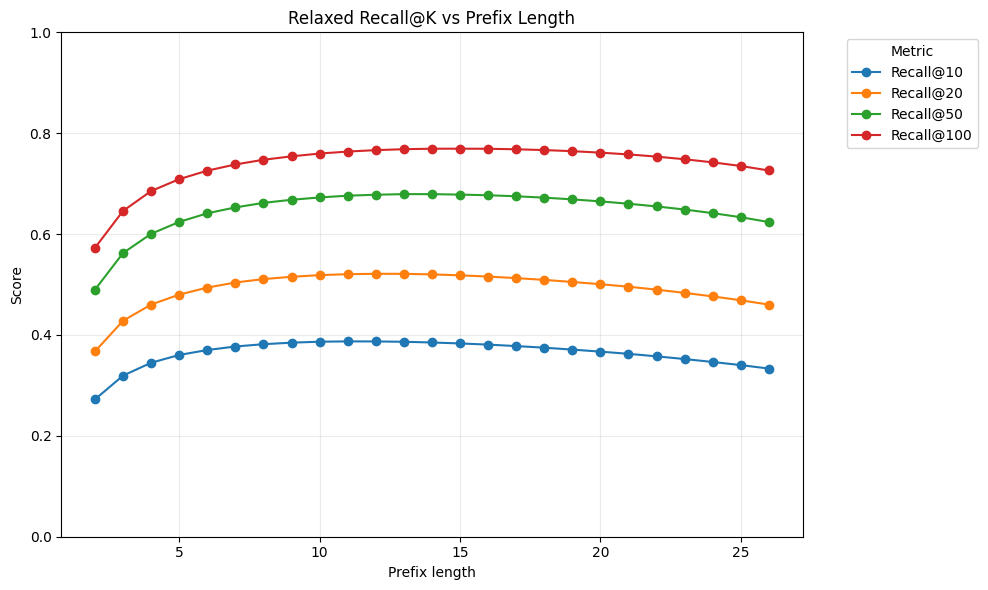

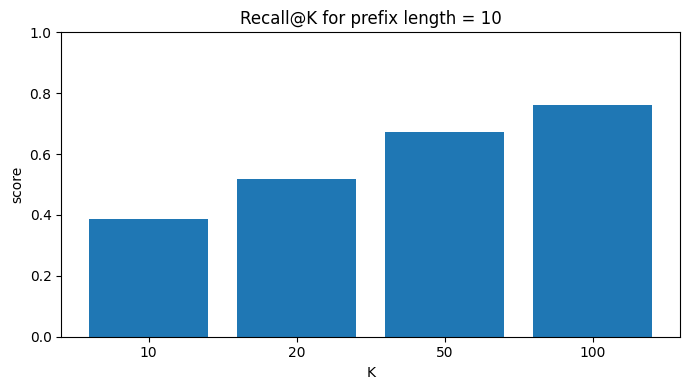

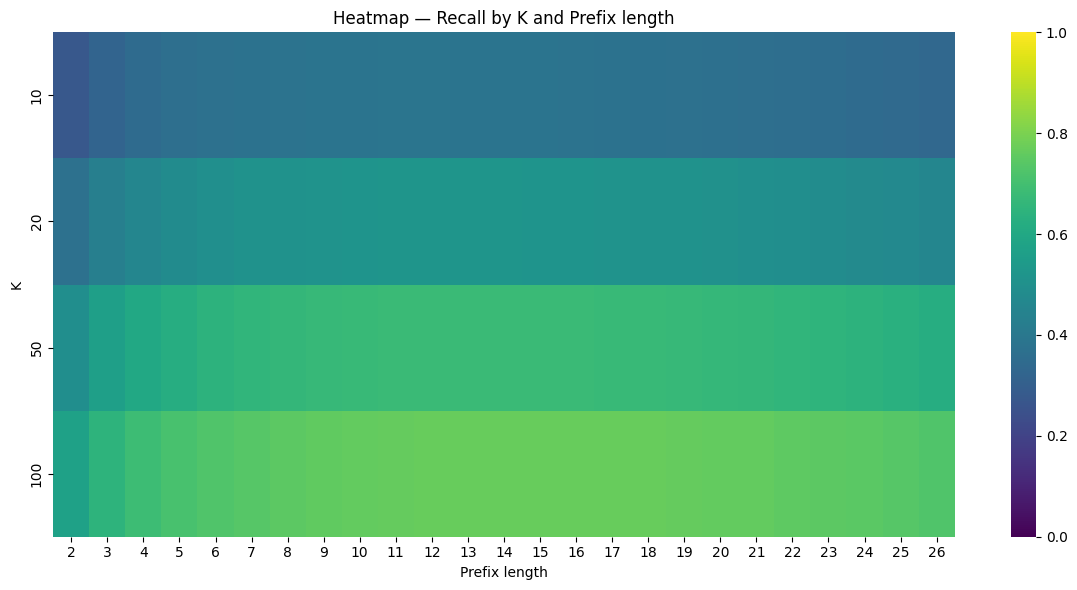

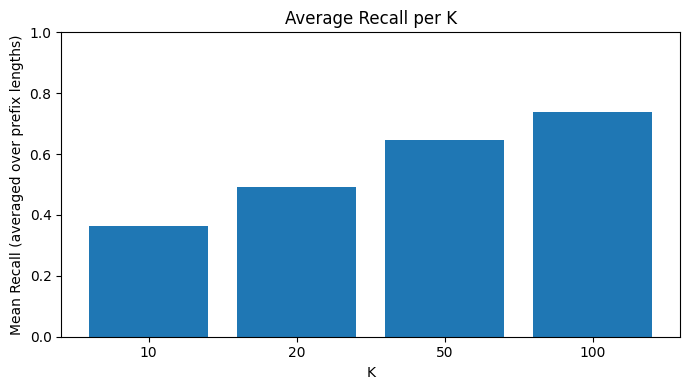

Saved plots to: /content/plots


In [7]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------- SETTINGS: change this to your CSV file ----------
save_path = "/content/drive/MyDrive/DL_project/results/relaxed_recall_by_prefix_length_1.csv"
out_dir = "plots"
os.makedirs(out_dir, exist_ok=True)

# --------- LOAD ----------
df = pd.read_csv(save_path)
df["prefix_length"] = df["prefix_length"].astype(int)

# detect recall columns robustly (handles "Recall@10" or "Recall10" or "recall@10")
recall_cols = [c for c in df.columns if re.match(r"(?i)^recall@?\d+", c)]
if not recall_cols:
    recall_cols = [c for c in df.columns if "recall" in c.lower()]
# sort by numeric K
recall_cols.sort(key=lambda c: int(re.search(r"(\d+)", c).group(1)))

# --------- 1) Multi-line plot: Recall@K vs prefix length ----------
plt.figure(figsize=(10, 6))
for c in recall_cols:
    plt.plot(df["prefix_length"], df[c], marker="o", label=c)
plt.xlabel("Prefix length")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Relaxed Recall@K vs Prefix Length")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "recall_vs_prefix_length.png"), dpi=200)
plt.show()

# --------- 2) Bar chart: Recall@K for a chosen prefix ----------
chosen = 10  # pick the prefix length you want to inspect
if chosen not in df["prefix_length"].values:
    # if exact prefix not available, pick nearest
    chosen = int(df["prefix_length"].iloc[(df["prefix_length"] - chosen).abs().argmin()])
row = df[df["prefix_length"] == chosen].iloc[0]
vals = [row[c] for c in recall_cols]
ks = [re.search(r"(\d+)", c).group(1) for c in recall_cols]

plt.figure(figsize=(7, 4))
plt.bar(ks, vals)
plt.ylim(0, 1)
plt.xlabel("K")
plt.ylabel("score")
plt.title(f"Recall@K for prefix length = {chosen}")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f"recall_bar_prefix_{chosen}.png"), dpi=200)
plt.show()

# --------- 3) Heatmap: K (rows) x prefix_length (columns) ----------
df_long = df.melt(id_vars="prefix_length", value_vars=recall_cols,
                  var_name="RecallK", value_name="Recall")
df_long["K"] = df_long["RecallK"].str.extract(r"(\d+)").astype(int)
heatmap = df_long.pivot(index="K", columns="prefix_length", values="Recall").sort_index()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap, annot=False, vmin=0, vmax=1, cmap="viridis")
plt.title("Heatmap — Recall by K and Prefix length")
plt.ylabel("K")
plt.xlabel("Prefix length")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "recall_heatmap.png"), dpi=200)
plt.show()

# --------- 4) Summary: mean recall per K (single-number summary) ----------
mean_per_k = df_long.groupby("K")["Recall"].mean().reset_index()
plt.figure(figsize=(7, 4))
plt.bar(mean_per_k["K"].astype(str), mean_per_k["Recall"])
plt.ylim(0, 1)
plt.xlabel("K")
plt.ylabel("Mean Recall (averaged over prefix lengths)")
plt.title("Average Recall per K")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "mean_recall_per_k.png"), dpi=200)
plt.show()

print("Saved plots to:", os.path.abspath(out_dir))


In [ ]:
## PERFORMANCE FOR 2-2-128 FOR 5 EPOCHS, after truncating to 30

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 7042 playlists
Recall@1: 0.0058
Recall@5: 0.0247
Recall@10: 0.0396
Recall@20: 0.0628
Recall@50: 0.1172
Recall@100: 0.1735


In [ ]:
## PERFORMANCE FOR 2-2-128 FOR 7 EPOCHS, after truncating to 30

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 7042 playlists
Recall@1: 0.0041
Recall@5: 0.0229
Recall@10: 0.0432
Recall@20: 0.0676
Recall@50: 0.1241
Recall@100: 0.1835


In [ ]:
## PERFORMANCE FOR 2-2-128 FOR 6 EPOCHS, after truncating to 30

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 7042 playlists
Recall@1: 0.0058
Recall@5: 0.0246
Recall@10: 0.0442
Recall@20: 0.0713
Recall@50: 0.1308
Recall@100: 0.1890


In [ ]:
## PERFORMANCE FOR 2-2-128 FOR 10 EPOCHS, smaller (300K) vocab

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0052
Recall@5: 0.0237
Recall@10: 0.0408
Recall@20: 0.0650
Recall@50: 0.1166
Recall@100: 0.1664


In [ ]:
## PERFORMANCE FOR 4-4-128 FOR 10 EPOCHS, smaller (300K) vocab

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0017
Recall@5: 0.0060
Recall@10: 0.0150
Recall@20: 0.0288
Recall@50: 0.0612
Recall@100: 0.0986


In [ ]:
## PERFORMANCE FOR 4-4-128 FOR 6 EPOCHS, smaller (300K) vocab

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0051
Recall@5: 0.0151
Recall@10: 0.0262
Recall@20: 0.0454
Recall@50: 0.0803
Recall@100: 0.1184


In [ ]:
## PERFORMANCE FOR 4-4-128 FOR 3 EPOCHS, smaller (300K) vocab

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0031
Recall@5: 0.0114
Recall@10: 0.0199
Recall@20: 0.0371
Recall@50: 0.0692
Recall@100: 0.1061


In [ ]:
## PERFORMANCE FOR 4-4-128 FOR 20 EPOCHS, smaller (300K) vocab

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0005
Recall@5: 0.0031
Recall@10: 0.0053
Recall@20: 0.0096
Recall@50: 0.0229
Recall@100: 0.0412


In [ ]:
## PERFORMANCE FOR 4-4-256 FOR 20 EPOCHS, smaller (300K) vocab

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0035
Recall@5: 0.0153
Recall@10: 0.0291
Recall@20: 0.0489
Recall@50: 0.0880
Recall@100: 0.1343


In [ ]:
## PERFORMANCE FOR 4-4-256 FOR 10 EPOCHS, smaller (300K) vocab

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0035
Recall@5: 0.0147
Recall@10: 0.0286
Recall@20: 0.0513
Recall@50: 0.0961
Recall@100: 0.1465


In [ ]:
## PERFORMANCE FOR 2-2-128 FOR 6 EPOCHS, smaller (300K) vocab

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0082
Recall@5: 0.0295
Recall@10: 0.0498
Recall@20: 0.0802
Recall@50: 0.1418
Recall@100: 0.1991


In [ ]:
## PERFORMANCE FOR 2-2-128 FOR 10 EPOCHS

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0065
Recall@5: 0.0284
Recall@10: 0.0477
Recall@20: 0.0719
Recall@50: 0.1219
Recall@100: 0.1743


In [ ]:
## PERFORMANCE FOR 2-2-128 FOR 6 EPOCHS

Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0067
Recall@5: 0.0294
Recall@10: 0.0481
Recall@20: 0.0767
Recall@50: 0.1359
Recall@100: 0.1935


In [ ]:
## PERFORMANCE FOR 4-4-256 FOR 3 EPOCHS


Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0021
Recall@5: 0.0083
Recall@10: 0.0143
Recall@20: 0.0273
Recall@50: 0.0525
Recall@100: 0.0894


In [ ]:
## PERFORMANCE FOR 2-2-128 FOR 3 EPOCHS


Ks      = [1, 5, 10, 20, 50, 100]
max_k   = max(Ks)
pad_id  = 0
max_len = 30

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits    = {k: 0 for k in Ks}
total_examples = 0

for seq in val_df["track_sequence"]:
    # 1) true next = last element
    true_id = seq[-1]

    # 2) prefix = all but last
    prefix = seq[:-1]
    #    truncate if too long
    if len(prefix) > max_len:
        prefix = prefix[-max_len:]

    # 3) pad to length max_len
    pad_len        = max_len - len(prefix)
    input_ids      = [pad_id]*pad_len + prefix
    attention_mask = [0]*pad_len + [1]*len(prefix)

    # 4) run the model
    with torch.no_grad():
        logits = model(
            torch.tensor([input_ids], device=device),
            attention_mask=torch.tensor([attention_mask], device=device)
        ).logits  # shape (1, max_len, vocab_size)

    # 5) pick out scores at the last real position
    #    that’s index (pad_len + len(prefix) - 1)
    pos    = pad_len + len(prefix) - 1
    scores = logits[0, pos, :].clone()
    #    mask out PAD
    scores[pad_id] = float("-inf")

    # 6) get top-max_k once
    topk = scores.topk(max_k).indices.tolist()

    # 7) accumulate hits
    for k in Ks:
        if true_id in topk[:k]:
            total_hits[k] += 1

    total_examples += 1

# 8) report
print(f"Evaluated on {total_examples} playlists")
for k in Ks:
    print(f"Recall@{k}: {total_hits[k] / total_examples:.4f}")

Evaluated on 10000 playlists
Recall@1: 0.0043
Recall@5: 0.0156
Recall@10: 0.0283
Recall@20: 0.0463
Recall@50: 0.0866
Recall@100: 0.1268


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits = 0
total_examples = 0

for batch in DataLoader(val_ds, batch_size=4):
    input_ids      = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels         = batch["labels"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        # take only the last-position logits: shape (B, vocab_size)
        last_logits = logits[:, -1, :]
        # get top-20 indices per example
        top20       = last_logits.topk(20, dim=-1).indices  # (B, 20)

        # true next-item IDs at that last position
        true_ids = labels[:, -1].unsqueeze(1)               # (B, 1)
        # check if true_ids appears in top20 row-wise
        hits = (top20 == true_ids).any(dim=-1).float()      # (B,)

        total_hits      += hits.sum().item()
        total_examples  += input_ids.size(0)

recall20 = total_hits / total_examples
print(f"▶️  Manual Recall@20 on validation: {recall20:.4f}")

▶️  Manual Recall@20 on validation: 0.9795


In [ ]:
Ks = [1, 5, 10, 20]
max_k = max(Ks)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# counters
total_hits   = {k: 0 for k in Ks}
total_examples = 0

for batch in DataLoader(val_ds, batch_size=4):
    input_ids      = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels         = batch["labels"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        # take only the last-position logits: shape (B, vocab_size)
        last_logits = logits[:, -1, :]
        # get top-max_k indices per example
        topk = last_logits.topk(max_k, dim=-1).indices   # (B, max_k)

        # true next-item IDs at that last position
        true_ids = labels[:, -1].unsqueeze(1)             # (B, 1)

        for k in Ks:
            # check if true_ids appears in the first k predictions
            hits_k = (topk[:, :k] == true_ids).any(dim=-1).float().sum().item()
            total_hits[k] += hits_k

        total_examples += input_ids.size(0)

# print recalls
for k in Ks:
    recall = total_hits[k] / total_examples
    print(f"Recall@{k}: {recall:.4f}")

Recall@1: 0.9731
Recall@5: 0.9769
Recall@10: 0.9780
Recall@20: 0.9795


In [ ]:
from itertools import chain
flat_ids = chain.from_iterable(train_df["track_sequence"])
print("Proto-vocab size:", len(set(flat_ids)))

Proto-vocab size: 595423


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

total_hits = 0
total_examples = 0

for batch in DataLoader(val_ds, batch_size=4):
    input_ids      = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels         = batch["labels"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits  # (B, L, V)

    # 1) Compute last real position for each example
    #    (sum of mask = number of real tokens in input_ids)
    seq_lens = attention_mask.sum(dim=1)          # (B,)
    last_pos = seq_lens - 1                       # (B,)

    # 2) For each example, pick the logits at its true "next" position
    #    and compute top-20 there
    batch_size, _, vocab_size = logits.shape
    for i in range(batch_size):
        lp = last_pos[i].item()
        scores = logits[i, lp, :]                 # (V,)
        top20  = torch.topk(scores, 20).indices    # (20,)
        true_id = labels[i, lp].item()
        if true_id in top20:
            total_hits += 1
    total_examples += batch_size

recall20 = total_hits / total_examples
print(f"▶️  True Recall@20 on validation: {recall20:.4f}")

▶️  True Recall@20 on validation: 0.8036


In [ ]:
# Define the Ks you care about
Ks = [1, 5, 10, 20]
max_k = max(Ks)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Initialize counters
total_hits = {k: 0 for k in Ks}
total_examples = 0

for batch in DataLoader(val_ds, batch_size=4):
    input_ids      = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels         = batch["labels"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits  # (B, L, V)

    # 1) Find for each sample the index of its last real token
    seq_lens = attention_mask.sum(dim=1)       # (B,)  count of real tokens
    last_pos = seq_lens - 1                    # (B,)  index of last token

    B, L, V = logits.shape
    # 2) For each sample, grab the logits at its true next position
    for i in range(B):
        lp = last_pos[i].item()
        scores = logits[i, lp, :]              # (V,)

        # 3) Get top-max_k predictions
        topk = torch.topk(scores, max_k).indices  # (max_k,)

        true_id = labels[i, lp].item()
        # 4) Check for each K whether true_id is in top-K
        for k in Ks:
            if true_id in topk[:k]:
                total_hits[k] += 1

    total_examples += B

# 5) Compute & print Recall@K
print("Recall@K on validation:")
for k in Ks:
    recall = total_hits[k] / total_examples
    print(f"  Recall@{k}: {recall:.4f}")

Recall@K on validation:
  Recall@1: 0.7794
  Recall@5: 0.7875
  Recall@10: 0.7938
  Recall@20: 0.8036


In [ ]:


# 1. Invert your remapping (new → old)
new2old = {new: old for old, new in track2new.items()}

# 2. Load the original track_id → track_key mapping
vocab_df = pd.read_parquet("/content/drive/MyDrive/DL_project/dataset/tokens/track_map.parquet")
id2name  = dict(zip(vocab_df["track_id"], vocab_df["track_key"]))

# 3. Pick an index in your val set
idx = 0  # change as desired

# 4. Decode the prefix
raw_seq_new = val_df.iloc[idx]["track_sequence"]
prefix_names = [
    "<PAD>" if tok == 0 else id2name[new2old[tok]]
    for tok in raw_seq_new
]
print("=== Playlist Prefix ===")
for i, name in enumerate(prefix_names, 1):
    print(f"{i:3d}. {name}")

# 5. Prepare the sample batch
sample = val_ds[idx]
input_ids      = sample["input_ids"].unsqueeze(0).to(model.device)
attention_mask = sample["attention_mask"].unsqueeze(0).to(model.device)
labels         = sample["labels"]

# 6. Locate the last real position
seq_len  = attention_mask.sum().item()
last_pos = seq_len - 1

# 7. Run model & grab top-10
model.eval()
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits

scores = logits[0, last_pos, :]
top10  = scores.topk(10).indices.tolist()

# 8. Map predictions back to names, handling PAD=0
pred_names = [
    "<PAD>" if tok == 0 else id2name[new2old[tok]]
    for tok in top10
]

# 9. Print true vs. predicted
true_tok  = labels[last_pos].item()
true_name = "<PAD>" if true_tok == 0 else id2name[new2old[true_tok]]

print("\n=== True Next Track ===")
print(">", true_name)

print("\n=== Top-10 Predictions ===")
for rank, name in enumerate(pred_names, 1):
    print(f"{rank:2d}. {name}")


=== Playlist Prefix ===
  1. Wing$––Macklemore & Ryan Lewis
  2. First––Cold War Kids
  3. We Are Young (Jersey Club)––Kyle Edwards
  4. Irresistible––Fall Out Boy
  5. Riptide––Vance Joy
  6. High You Are––What So Not
  7. Like That––Jack & Jack
  8. House Of Memories––Panic! At The Disco
  9. I Write Sins Not Tragedies––Panic! At The Disco
 10. Vegas Lights––Panic! At The Disco
 11. Different Colors––WALK THE MOON
 12. No Role Modelz––J. Cole
 13. Invincible––Deaf Kev
 14. Roses - Zaxx Remix––The Chainsmokers
 15. White Iverson––Post Malone
 16. Something Big––Shawn Mendes
 17. Trophies––Young Money
 18. oui––Jeremih
 19. Trndsttr (feat. M. Maggie) - Lucian Remix––Black Coast
 20. All Time Low––Jon Bellion
 21. Marble Soda––Shawn Wasabi
 22. Six Shooter––Coyote Kisses
 23. Ride––Twenty One Pilots
 24. Ultimate––Denzel Curry
 25. Lean On (feat. MØ & DJ Snake)––Major Lazer
 26. Out Of My League - Peking Duk Remix––Fitz and The Tantrums
 27. Ways To Go––Grouplove
 28. Ribs––Lorde
 29. W

In [ ]:
# 1. Parameters
max_len      = 30
pad_token_id = 0

# 2. Find a validation playlist with at least max_len+1 tracks
#    (so the “next” track is real, not PAD)
idx = next(
    i for i, seq in enumerate(val_df["track_sequence"])
    if len(seq) > max_len
)

# 3. Extract the raw list of track_ids, then truncate to the last max_len items
raw_seq   = val_df.iloc[idx]["track_sequence"]
trunc_seq = raw_seq[-max_len:]       # length == max_len
prefix    = trunc_seq[:-1]           # length == max_len-1
true_next = trunc_seq[-1]            # the “real” next track

# 4. Build model inputs
pad_len        = max_len - len(prefix)
input_ids      = [pad_token_id]*pad_len + prefix
attention_mask = [0]*pad_len + [1]*len(prefix)

# 5. Decode & print the prefix
print("=== Playlist Prefix ===")
for i, tok in enumerate(prefix, 1):
    print(f"{i:2d}. { id2name[new2old[tok]] }")

# 6. Show the true next track
print("\n=== True Next Track ===")
print(">", id2name[new2old[true_next]])

# 7. Run the model
model.eval()
with torch.no_grad():
    logits = model(
        torch.tensor([input_ids]).to(model.device),
        attention_mask=torch.tensor([attention_mask]).to(model.device)
    ).logits

# 8. Get & decode top-10 predictions
top20 = logits[0, -1].topk(30).indices.tolist()
print("\n=== Top-10 Predictions ===")
for rank, tok in enumerate(top20, 1):
    if tok == 0:
        name = "<PAD>"
    else:
        # fallback to “Unknown” if something’s really off
        name = id2name.get(new2old.get(tok), "Unknown")
    print(f"{rank:2d}. {name}")

=== Playlist Prefix ===
 1. Six Shooter––Coyote Kisses
 2. Ride––Twenty One Pilots
 3. Ultimate––Denzel Curry
 4. Lean On (feat. MØ & DJ Snake)––Major Lazer
 5. Out Of My League - Peking Duk Remix––Fitz and The Tantrums
 6. Ways To Go––Grouplove
 7. Ribs––Lorde
 8. White Teeth Teens––Lorde
 9. The Buzz (feat. Big K.R.I.T., Mataya & Young Tapz) - Bonus Track––Hermitude
10. Borderline - Vanic Remix––Tove Styrke
11. Flashed Junk Mind––Milky Chance
12. Father Stretch My Hands Pt. 1––Kanye West
13. Wake Me Up - Radio Edit––Avicii
14. Hey Brother––Avicii
15. Nice Guys––Chester See, Kevjumba & Ryan Higa
16. Swg (feat. Golden)––Ryan Higa
17. Radioactive––Imagine Dragons
18. Young, Wild & Free (feat. Bruno Mars) - feat. Bruno Mars––Snoop Dogg
19. Count On Me––Bruno Mars
20. Want to Want Me––Jason Derulo
21. Panda––Desiigner
22. The Monster––Eminem
23. Love The Way You Lie––Eminem
24. Forever––Drake
25. Lighters––Bad Meets Evil
26. Be Right There––Diplo
27. Don't Let Me Down––The Chainsmokers
28

In [ ]:
from torch.utils.data import DataLoader

# Define the Ks you care about
Ks = [1, 5, 10, 20]
max_k = max(Ks)
pad_token_id = 0   # your PAD index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Initialize counters
total_hits = {k: 0 for k in Ks}
total_examples = 0

for batch in DataLoader(val_ds, batch_size=4):
    input_ids      = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels         = batch["labels"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits  # (B, L, V)

    # find the last real token position for each sequence
    seq_lens = attention_mask.sum(dim=1)   # (B,)
    last_pos = seq_lens - 1                # (B,)

    for i in range(logits.size(0)):
        lp = last_pos[i].item()
        true_id = labels[i, lp].item()
        # skip if there is no real next item
        if true_id == pad_token_id:
            continue

        # get scores for the prediction position
        scores = logits[i, lp, :].clone()
        # mask out PAD so it never appears in top-k
        scores[pad_token_id] = float('-inf')

        # get top-max_k predictions
        topk = torch.topk(scores, max_k).indices  # (max_k,)

        # count hits for each K
        for k in Ks:
            if true_id in topk[:k]:
                total_hits[k] += 1

        total_examples += 1

# print Recall@K
print("Recall@K on validation:")
for k in Ks:
    recall = total_hits[k] / total_examples
    print(f"total examples: {total_examples}")
    print(f"  Recall@{k}: {recall:.4f}")

Recall@K on validation:
total examples: 1895
  Recall@1: 0.0095
total examples: 1895
  Recall@5: 0.0332
total examples: 1895
  Recall@10: 0.0607
total examples: 1895
  Recall@20: 0.1034


In [ ]:
from collections import Counter

# Count frequencies in train_df
all_tracks = [t for seq in train_df["track_sequence"] for t in seq]
top20 = [track for track, _ in Counter(all_tracks).most_common(20)]

# Evaluate pop-baseline Recall@20
hits = 0
for seq in val_df["track_sequence"]:
    true = seq[-1]
    if true in top20:
        hits += 1
print(f"Popularity - Recall@20: {hits/len(val_df):.4f}")

Popularity - Recall@20: 0.0120


In [ ]:
####################################

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# 6. Eval on validation
eval_metrics = trainer.evaluate()
print(">> Validation metrics:")
for k,v in eval_metrics.items():
    print(f"   {k}: {v:.4f}")

# this will include:
#   eval_loss
#   eval_recall@20   ← your primary metric